preprocess

In [ ]:
from pathlib import Path

import numpy as np
import mne
from mne import (
    Annotations,
    Report,
    concatenate_raws,
    events_from_annotations,
    make_fixed_length_epochs,
)
from mne.channels import make_standard_montage
from mne.io import read_raw
from mne.preprocessing import ICA

from mne_icalabel import label_components
from autoreject import AutoReject


In [ ]:
bids_root = Path("/Volumes/Extreme_SSD/payam_data/Tide_data/BIDS")

def preprocess(subject_id, bids_root=bids_root):

    site_map = {
        "1": "austin",
        "2": "dublin",
        "3": "ghent",
        "4": "illinois",
        "5": "regensburg",
        "6": "tuebingen",
        "7": "zuerich"
        }

    site_params = {
        "austin": {
            "suffix": "vhdr",
            "chs_to_drop": ["VREF"],
            "montage": "GSN-HydroCel-64_1.0",
        },
        "dublin": {
            "suffix": "bdf",
            "chs_to_drop": [f"EXG{i}" for i in range(9)] + ["Status"],
            "montage": "easycap-M1",
        },
        "ghent": {
            "suffix": "vhdr",
            "chs_to_drop": ["M1", "M2", "PO5", "PO6", "EOG"],
            "montage": "easycap-M1",
        },
        "illinois": {
            "suffix": "vhdr",
            "chs_to_drop": ["VEOG", "HEOG", "Trigger", "F11", "F12",
                            "FT11", "FT12", "M1", "M2", "Cb1", "Cb2"],
            "montage": "easycap-M1",
        },
        "regensburg": {
            "suffix": "vhdr",
            "chs_to_drop": ["audio"],
            "montage": "easycap-M1",
        },
        "tuebingen": {
            "suffix": "vhdr",
            "chs_to_drop": ["audio", "aux1"],
            "montage": "easycap-M1",
        },
        "zuerich": {
            "suffix": "vhdr",
            "chs_to_drop": ['Pulse', 'GSR', 'X', 'Y', 'Z', 'Resp', 'Photo', 'Audio',
                            "O1", "O2", "PO7", "PO8"],
            "montage": "easycap-M1",
        },
    }

    ## get site specific parameters
    site = site_map.get(str(subject_id)[0], "unknown")
    folder = bids_root / f"sub-{subject_id}" / "ses-01" / "eeg"
    params = site_params.get(site, {"suffix": "vhdr", "chs_to_drop": [], "montage": "easycap-M1"})
    suffix = params["suffix"]
    chs_to_drop = params["chs_to_drop"]
    montage_name = params["montage"]
    
    fname = folder / f"sub-{subject_id}_ses-01_task-rest_desc-{site}_eeg.{suffix}"
    sfreq = 250.0
    l_freq = 1.0
    h_freq = 100.0
    crop_duration = 5.0
    epoch_duration = 10.0
    zurich_cutoff = 3.0
    overwrite = True

    raw = read_raw(fname, preload=True)
    raw.drop_channels(ch_names=chs_to_drop, on_missing="warn")
    montage = make_standard_montage(montage_name)
    raw.set_montage(montage, match_case=False, on_missing="warn")

    ## annotations
    if site == "zuerich":
        if subject_id == "70006":
            ec_event_id = 'Stimulus/S  4'
        else:
            ec_event_id = 'Stimulus/S  5'

        events, event_ids = events_from_annotations(raw)
        event_key = event_ids[ec_event_id]
        events_ec = events[events[:, 2] == event_key]
        if len(events_ec) != 5:
            raise ValueError(f"number close eye events should be 5, got {len(events_ec)} instead.") 

        onsets = (events_ec[:, 0] + zurich_cutoff * raw.info["sfreq"]) / raw.info["sfreq"]
        duration = (60 - 2 * zurich_cutoff) * np.ones(shape=len(onsets))
        annots = Annotations(onsets, duration, description="ec")
        raw.set_annotations(annots)
        raw = concatenate_raws(raw.crop_by_annotations())
    
    else:
        raw.annotations.delete(range(len(raw.annotations)))

    ## preproc_1
    raw.crop(tmin=crop_duration, tmax=raw.times[-1] - crop_duration)
    raw.filter(l_freq=l_freq, h_freq=h_freq)
    raw.resample(sfreq=sfreq)
    raw.set_eeg_reference("average", projection=False)
    epochs_1 = make_fixed_length_epochs(raw, duration=epoch_duration, preload=True)
    epochs_1.save(folder / "preproc_1-epo.fif", overwrite=overwrite)

    ## preproc_2
    ar = AutoReject(
                    n_interpolate=np.array([1, 4, 8]),
                    consensus=np.linspace(0, 1.0, 11),
                    cv=5,
                    n_jobs=1,
                    random_state=11,
                    verbose=True
                    )
    ar.fit(epochs_1)
    epochs_2, reject_log = ar.transform(epochs_1, return_log=True)
    epochs_2.save(folder / "preproc_2-epo.fif", overwrite=overwrite)

    ## preproc 3
    ica = ICA(n_components=0.999, method='fastica')
    try:
        ica.fit(epochs_2)
    except:
        ica = ICA(n_components=5, method='fastica')
        ica.fit(epochs_2)

    ic_labels = label_components(epochs_2, ica, method="iclabel")["labels"]
    artifact_idxs = [idx for idx, label in enumerate(ic_labels) \
                    if not label in ["brain", "other"]]
    epochs_3 = ica.apply(epochs_2.copy(), exclude=artifact_idxs)
    epochs_3.save(folder / "preproc_3-epo.fif", overwrite=overwrite)

    ## create report
    ## preproc_1
    report = Report(title="10001")
    report.add_epochs(epochs=epochs_1, image_kwargs={}, psd=False, title='Epochs_preproc1')

    ## preproc_2
    fig_reject = reject_log.plot(show=False)
    report.add_figure(fig=fig_reject, title="autoreject log", image_format="PNG")
    fig_drop = epochs_2.plot_drop_log()
    report.add_figure(fig=fig_drop, title="epochs drop log", image_format="PNG")

    ## preproc_3
    report.add_ica(
        ica=ica,
        title="ICA cleaning",
        picks=artifact_idxs,
        inst=None,
        eog_evoked=None,
        eog_scores=None,
        n_jobs=None
    )
    artifact_labels = np.array(ic_labels)[artifact_idxs].tolist()
    label_html = "<p>ICLabel classification results:</p>\n<ol>\n"
    for label in artifact_labels:
        label_html += f"  <li>{label}</li>\n"
    label_html += "</ol>"
    report.add_html(title="ICLabel Results", html=label_html)
    report.save(fname=folder / "report.html", open_browser=False, overwrite=overwrite)



In [ ]:
%matplotlib qt
import mne
raw = mne.read_epochs("/Users/payamsadeghishabestari/Tinnorm/src/eeg/preproc_2-epo.fif")
eps.plot()

Reading /Users/payamsadeghishabestari/Tinnorm/src/eeg/preproc_2-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    9996.00 ms
        0 CTF compensation matrices available
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using pyopengl with version 3.1.9


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [97]:
montage = make_standard_montage("GSN-HydroCel-64_1.0")
raw.set_montage(montage, match_case=False, on_missing="warn")


# raw.set_channel_types({"E61": "eog", "E62": "eog", "E63": "eog", "E64": "eog"})
# raw.drop_channels("VREF")

<EpochsFIF | 24 events (all good), 0 – 9.996 s (baseline off), ~29.4 MiB, data loaded,
 '1': 24>

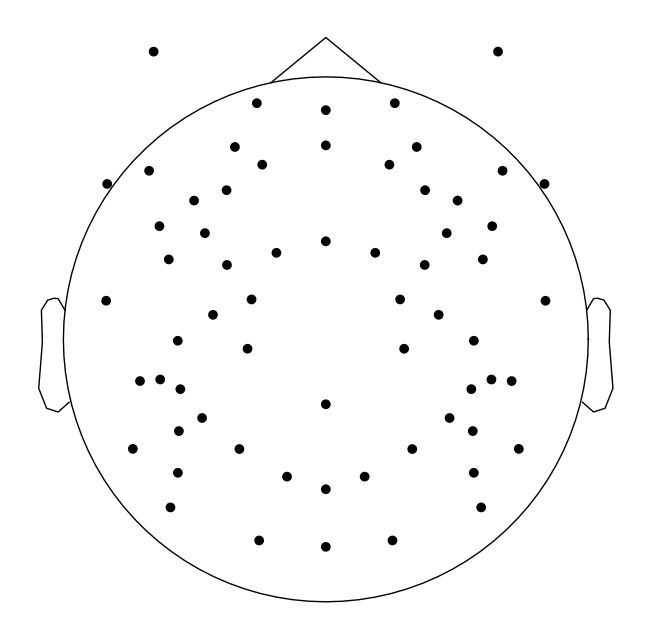

In [83]:
eps.plot_sensors()

In [70]:
raw.plot()

Using pyopengl with version 3.1.9


Channels marked as bad:
none


<RawBrainVision | sub-10001_ses-01_task-rest_desc-austin_eeg.eeg, 64 x 308616 (308.6 s), ~94 KiB, data not loaded>

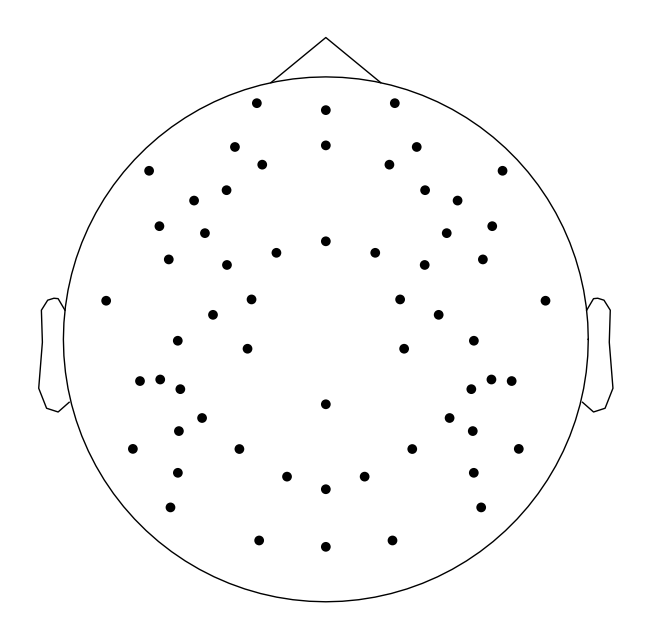

In [48]:
raw.plot_sensors()

In [55]:
raw.plot()

Using pyopengl with version 3.1.9


Channels marked as bad:
none


In [98]:
ica = mne.preprocessing.ICA(n_components=0.999, max_iter=1000, method='infomax', fit_params=dict(extended=True), random_state=42)
ica.fit(eps)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 51 components
Computing Extended Infomax ICA
Fitting ICA took 20.8s.


Method,infomax
Fit parameters,extended=Truemax_iter=1000
Fit,1000 iterations on epochs (60000 samples)
ICA components,51
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [85]:
ic_labels = label_components(raw, ica, method="iclabel")["labels"]
artifact_idxs = [idx for idx, label in enumerate(ic_labels) \
                if not label in ["brain", "other"]]

In [99]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731 with 11 Axes>]

In [92]:
ica.plot_sources(eps)

Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using pyopengl with version 3.1.9


In [89]:
label_components(raw, ica, method="iclabel")

{'y_pred_proba': array([0.86330646, 0.7684906 , 0.99805975, 0.7508517 , 0.4753862 ,
        0.5878716 , 0.8340632 , 0.9266474 , 0.3070032 , 0.7510081 ,
        0.98783034, 0.86105585, 0.47972625, 0.74313515, 0.51250774,
        0.97881234, 0.99105877, 0.5402998 , 0.45193076, 0.78058404,
        0.9989488 , 0.95928264, 0.8124441 , 0.5632155 , 0.40839452,
        0.58479995, 0.69382584, 0.47034478, 0.57761455, 0.96889466,
        0.5390106 , 0.95580465, 0.7223197 , 0.70762795, 0.76975113,
        0.95530266, 0.59964573, 0.37313762, 0.69619054, 0.4444762 ,
        0.58471537, 0.98856187, 0.82103014, 0.6921221 , 0.47232866,
        0.5222595 , 0.43451005, 0.7453196 , 0.9518694 , 0.265364  ,
        0.41641408], dtype=float32),
 'labels': ['brain',
  'eye blink',
  'eye blink',
  'brain',
  'eye blink',
  'brain',
  'eye blink',
  'eye blink',
  'brain',
  'brain',
  'brain',
  'muscle artifact',
  'brain',
  'eye blink',
  'muscle artifact',
  'brain',
  'brain',
  'brain',
  'other',
  'b

In [100]:
ica.apply(eps, exclude=range(10))

Applying ICA to Epochs instance
    Transforming to ICA space (51 components)
    Zeroing out 10 ICA components
    Projecting back using 64 PCA components


<EpochsFIF | 24 events (all good), 0 – 9.996 s (baseline off), ~29.4 MiB, data loaded,
 '1': 24>

In [ ]:
eps.plot()

Using pyopengl with version 3.1.9


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
